**가위 바위 보 이미지 분류 모델  **  
이번 프로젝트에서는 직접 찍은 가위 바위 보 사진과 아이펠 학우 분의 사진을 가지고 이미지 분류 작업을 하였습니다.  
학습 데이터는 학우 분의 사진 100장을 이용했고  
테스트 데이터는 저의 사진 25장을 이용해서 8:2 비율로 배분했습니다.  
학습과 테스트는 lms에서 제공한 lenet 모델과 hyperparameter tuning을 적용한 모델들을 활용했습니다.  




In [196]:
#필요한 이미지 불러오기 
from PIL import Image
import glob
import os
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
import numpy as np

In [265]:
#train set  경로 설정 
train_image_dir_path = "/content/drive/MyDrive/aiffel/data/mineon_rsp/data/train"

#test set 경로 
test_image_dir_path = "/content/drive/MyDrive/aiffel/data/mineon_rsp/data/test"

In [266]:
#train data set 개수 확인 
print("가위 이미지: {0}".format(len(glob.glob(train_image_dir_path +'/scissor/*.jpg' ))))
print("바위 이미지: {0}".format(len(glob.glob(train_image_dir_path + '/rock/*.jpg' ))))
print("보 이미지: {0}".format(len(glob.glob(train_image_dir_path + '/paper/*.jpg' ))))
print("=======================================================")

#test data set 개수 확인 => 100, 100
print("가위 이미지: {0}".format(len(glob.glob(test_image_dir_path +'/scissor/*.jpg' ))))
print("바위 이미지: {0}".format(len(glob.glob(test_image_dir_path +'/rock/*.jpg' ))))
print("보 이미지: {0}".format(len(glob.glob(test_image_dir_path +'/paper/*.jpg' ))))

가위 이미지: 100
바위 이미지: 100
보 이미지: 100
가위 이미지: 100
바위 이미지: 100
보 이미지: 100


In [267]:
#이미지 사이즈 28 x 28로 줄이기 
def resize_images(img_path):
    images=glob.glob(img_path + "/*.jpg")  
    
    print(len(images), " images to be resized.")

    target_size=(28,28)  
    for img in images:
        old_img=Image.open(img)
        new_img=old_img.resize(target_size,Image.ANTIALIAS)
        new_img.save(img, "JPEG")

    print(len(images), " images resized.")

#학습 데이터 적용
print("train image resize")
image_dir_path = train_image_dir_path + "/scissor"
resize_images(image_dir_path)

image_dir_path = train_image_dir_path + "/rock"
resize_images(image_dir_path)

image_dir_path = train_image_dir_path + "/paper"
resize_images(image_dir_path)

print("============================================")

#테스트 데이터 적용
print("test image resize")
image_dir_path = test_image_dir_path + "/scissor"
resize_images(image_dir_path)

image_dir_path = test_image_dir_path + "/rock"
resize_images(image_dir_path)

image_dir_path = test_image_dir_path + "/paper"
resize_images(image_dir_path)

train image resize
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
test image resize
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.


In [268]:
#train data 읽어 들이는 load_data 함수 
def load_data(img_path, number_of_data=300): 
    
    img_size=28
    color=3
   
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color) #이미지 담을 행렬
    labels=np.zeros(number_of_data,dtype=np.int32) #가위, 바위, 보 label 담을 행렬

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img   
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    
        labels[idx]=2   # 보 : 2
        idx=idx+1

    if img_path.endswith('train'):
      print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")   
    else:
      print("테스트데이터(x_test)의 이미지 개수는", idx,"입니다.")
    return imgs, labels 

(x_train, y_train) = load_data(train_image_dir_path, number_of_data=300) #x_train은 이미지 저장, y_train은 label 저장
x_train = x_train/255.0 #정규화

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

(x_test, y_test) = load_data(test_image_dir_path, number_of_data=300)

x_test = x_test[:24] #테스트 데이터 25개만 사용 
x_test = x_test/255.0 #테스트 데이터 정규화 

y_test = y_test[:24] #테스트 label 25개만 사용

print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

학습데이터(x_train)의 이미지 개수는 300 입니다.
x_train shape: (300, 28, 28, 3)
y_train shape: (300,)
테스트데이터(x_test)의 이미지 개수는 300 입니다.
x_test shape: (24, 28, 28, 3)
y_test shape: (24,)


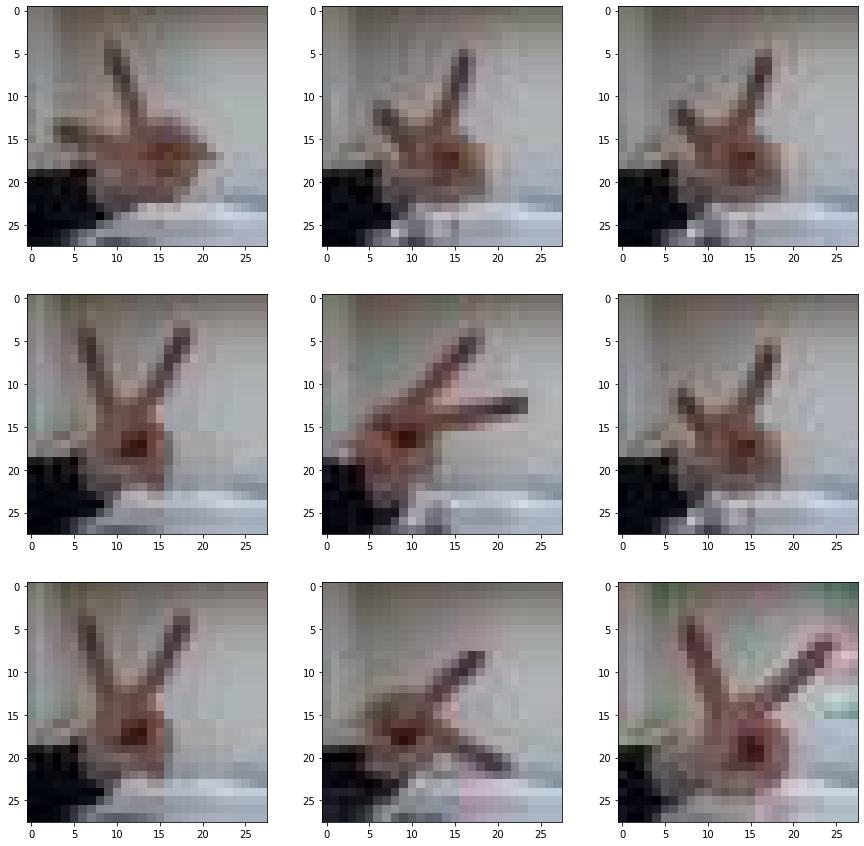

In [195]:
#이미지 불러오기 
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15,15)) #9개 이미지 
axs = np.ravel(axs)

for i in range(len(axs)):
    plt.sca(axs[i])
    plt.imshow(x_train[i])
     
plt.show()

In [240]:
#lenet model 7 layers
# LeNet-5 model

input_shape = (28,28,3) #입력 이미지 형태
num_class = 3 #class 3개 

model1=keras.models.Sequential()
model1.add(keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=input_shape)) #다양한 이미지의 특징, 입력 이미지의 형태
model1.add(keras.layers.MaxPool2D(2,2))
model1.add(keras.layers.Conv2D(32, (3,3), activation='relu'))
model1.add(keras.layers.MaxPooling2D((2,2)))
model1.add(keras.layers.Flatten())
model1.add(keras.layers.Dense(32, activation='relu')) 
model1.add(keras.layers.Dense(num_class, activation='softmax'))

model1.summary()

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_81 (Conv2D)          (None, 26, 26, 16)        448       
                                                                 
 max_pooling2d_63 (MaxPoolin  (None, 13, 13, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_82 (Conv2D)          (None, 11, 11, 32)        4640      
                                                                 
 max_pooling2d_64 (MaxPoolin  (None, 5, 5, 32)         0         
 g2D)                                                            
                                                                 
 flatten_38 (Flatten)        (None, 800)               0         
                                                                 
 dense_84 (Dense)            (None, 32)              

In [217]:
#학습방식 환경설정 
model1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [199]:
#epoch: 10
model1.fit(x_train, y_train, epochs=10)

Epoch 1/10
10/10 [==============================] - 0s 19ms/step - loss: 0.9596 - accuracy: 0.7233
Epoch 2/10
10/10 [==============================] - 0s 18ms/step - loss: 0.9373 - accuracy: 0.7767
Epoch 3/10
10/10 [==============================] - 0s 20ms/step - loss: 0.9144 - accuracy: 0.7300
Epoch 4/10
10/10 [==============================] - 0s 21ms/step - loss: 0.8904 - accuracy: 0.7267
Epoch 5/10
10/10 [==============================] - 0s 20ms/step - loss: 0.8622 - accuracy: 0.7533
Epoch 6/10
10/10 [==============================] - 0s 20ms/step - loss: 0.8406 - accuracy: 0.7267
Epoch 7/10
10/10 [==============================] - 0s 20ms/step - loss: 0.7910 - accuracy: 0.7133
Epoch 8/10
10/10 [==============================] - 0s 20ms/step - loss: 0.7704 - accuracy: 0.7767
Epoch 9/10
10/10 [==============================] - 0s 22ms/step - loss: 0.7283 - accuracy: 0.7600
Epoch 10/10
10/10 [==============================] - 0s 21ms/step - loss: 0.7009 - accuracy: 0.8000


In [200]:
test_loss, test_accuracy = model1.evaluate(x_test,y_test, verbose=2) #test 정확도가 1인 것으로 보아 label 또는 data의 leakage가 발생해 보임
print("test_loss: {} ".format(test_loss)) #손실
print("test_accuracy: {}".format(test_accuracy)) #정확도

1/1 - 0s - loss: 0.6969 - accuracy: 1.0000 - 157ms/epoch - 157ms/step
test_loss: 0.6969335079193115 
test_accuracy: 1.0


In [210]:
model1.fit(x_train, y_train, epochs=20) #epoch: 20 

Epoch 1/20
10/10 [==============================] - 1s 22ms/step - loss: 1.0732 - accuracy: 0.3833
Epoch 2/20
10/10 [==============================] - 0s 22ms/step - loss: 0.9852 - accuracy: 0.6433
Epoch 3/20
10/10 [==============================] - 0s 21ms/step - loss: 0.8520 - accuracy: 0.7000
Epoch 4/20
10/10 [==============================] - 0s 22ms/step - loss: 0.7042 - accuracy: 0.7500
Epoch 5/20
10/10 [==============================] - 0s 20ms/step - loss: 0.5770 - accuracy: 0.8433
Epoch 6/20
10/10 [==============================] - 0s 22ms/step - loss: 0.5075 - accuracy: 0.8367
Epoch 7/20
10/10 [==============================] - 0s 22ms/step - loss: 0.4399 - accuracy: 0.8833
Epoch 8/20
10/10 [==============================] - 0s 22ms/step - loss: 0.3628 - accuracy: 0.9067
Epoch 9/20
10/10 [==============================] - 0s 23ms/step - loss: 0.3320 - accuracy: 0.9033
Epoch 10/20
10/10 [==============================] - 0s 22ms/step - loss: 0.2823 - accuracy: 0.9333
Epoch 11/

In [211]:
test_loss, test_accuracy = model1.evaluate(x_test,y_test, verbose=2) #정확도 감소 
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

1/1 - 0s - loss: 0.6119 - accuracy: 0.6250 - 150ms/epoch - 150ms/step
test_loss: 0.6119138598442078 
test_accuracy: 0.625


In [218]:
#epoch: 30
model1.fit(x_train, y_train, epochs=30)

Epoch 1/30
10/10 [==============================] - 1s 22ms/step - loss: 1.0549 - accuracy: 0.4133
Epoch 2/30
10/10 [==============================] - 0s 21ms/step - loss: 0.9683 - accuracy: 0.5367
Epoch 3/30
10/10 [==============================] - 0s 21ms/step - loss: 0.8063 - accuracy: 0.7867
Epoch 4/30
10/10 [==============================] - 0s 20ms/step - loss: 0.6441 - accuracy: 0.7100
Epoch 5/30
10/10 [==============================] - 0s 23ms/step - loss: 0.5114 - accuracy: 0.8067
Epoch 6/30
10/10 [==============================] - 0s 21ms/step - loss: 0.4578 - accuracy: 0.8033
Epoch 7/30
10/10 [==============================] - 0s 21ms/step - loss: 0.3979 - accuracy: 0.8567
Epoch 8/30
10/10 [==============================] - 0s 22ms/step - loss: 0.4187 - accuracy: 0.8267
Epoch 9/30
10/10 [==============================] - 0s 21ms/step - loss: 0.3645 - accuracy: 0.8767
Epoch 10/30
10/10 [==============================] - 0s 23ms/step - loss: 0.3139 - accuracy: 0.9233
Epoch 11/

In [219]:
test_loss, test_accuracy = model1.evaluate(x_test,y_test, verbose=2) 
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

1/1 - 0s - loss: 0.3760 - accuracy: 0.8333 - 142ms/epoch - 142ms/step
test_loss: 0.3759976923465729 
test_accuracy: 0.8333333134651184


기존 model1에 optimizer를 RMSprop으로 다르게 적용했다.  
epoch 수는 기존과 동일하게 10, 20, 30으로 설정하고 비교하였다.  

In [233]:
model1.compile(optimizer='RMSprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [226]:
#epoch: 10
model1.fit(x_train, y_train, epochs=10)

Epoch 1/10
10/10 [==============================] - 1s 21ms/step - loss: 1.0286 - accuracy: 0.4533
Epoch 2/10
10/10 [==============================] - 0s 21ms/step - loss: 0.8304 - accuracy: 0.7133
Epoch 3/10
10/10 [==============================] - 0s 20ms/step - loss: 0.6831 - accuracy: 0.7667
Epoch 4/10
10/10 [==============================] - 0s 24ms/step - loss: 0.5278 - accuracy: 0.8267
Epoch 5/10
10/10 [==============================] - 0s 23ms/step - loss: 0.4514 - accuracy: 0.8400
Epoch 6/10
10/10 [==============================] - 0s 21ms/step - loss: 0.3984 - accuracy: 0.8667
Epoch 7/10
10/10 [==============================] - 0s 21ms/step - loss: 0.3076 - accuracy: 0.9267
Epoch 8/10
10/10 [==============================] - 0s 20ms/step - loss: 0.3364 - accuracy: 0.8600
Epoch 9/10
10/10 [==============================] - 0s 24ms/step - loss: 0.2541 - accuracy: 0.9233
Epoch 10/10
10/10 [==============================] - 0s 20ms/step - loss: 0.2212 - accuracy: 0.9400


In [227]:
test_loss, test_accuracy = model1.evaluate(x_test,y_test, verbose=2) 
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

1/1 - 0s - loss: 0.4908 - accuracy: 0.9167 - 133ms/epoch - 133ms/step
test_loss: 0.49084725975990295 
test_accuracy: 0.9166666865348816


In [234]:
#epoch: 20
model1.fit(x_train, y_train, epochs=20)

Epoch 1/20
10/10 [==============================] - 1s 21ms/step - loss: 1.0965 - accuracy: 0.4467
Epoch 2/20
10/10 [==============================] - 0s 21ms/step - loss: 1.0457 - accuracy: 0.5467
Epoch 3/20
10/10 [==============================] - 0s 22ms/step - loss: 0.9620 - accuracy: 0.6200
Epoch 4/20
10/10 [==============================] - 0s 22ms/step - loss: 0.8837 - accuracy: 0.6367
Epoch 5/20
10/10 [==============================] - 0s 21ms/step - loss: 0.7497 - accuracy: 0.7233
Epoch 6/20
10/10 [==============================] - 0s 22ms/step - loss: 0.6693 - accuracy: 0.8000
Epoch 7/20
10/10 [==============================] - 0s 20ms/step - loss: 0.5625 - accuracy: 0.8700
Epoch 8/20
10/10 [==============================] - 0s 21ms/step - loss: 0.5493 - accuracy: 0.8700
Epoch 9/20
10/10 [==============================] - 0s 22ms/step - loss: 0.4502 - accuracy: 0.8767
Epoch 10/20
10/10 [==============================] - 0s 22ms/step - loss: 0.3969 - accuracy: 0.8933
Epoch 11/

In [235]:
test_loss, test_accuracy = model1.evaluate(x_test,y_test, verbose=2) #epoch 수 증가해도 정확도는 떨어졌다. overfitting이 발생해서 이러한 결과가 나온 것 같다. 
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

1/1 - 0s - loss: 0.6183 - accuracy: 0.7083 - 142ms/epoch - 142ms/step
test_loss: 0.6182637810707092 
test_accuracy: 0.7083333134651184


model2는 기존 model1에서 layer 수는 그대로 유지하돼 channel 수를 늘려서 설정했다.  
optimizer도 그대로 Adam과 RMSprop를 적용했다.  


In [269]:
#model2 
#7layers 동일, channerl수 증가해서 변경 
model2=keras.models.Sequential()
model2.add(keras.layers.Conv2D(128, (3,3), activation='relu', input_shape=input_shape)) #다양한 이미지의 특징, 입력 이미지의 형태
model2.add(keras.layers.MaxPool2D(2,2))
model2.add(keras.layers.Conv2D(64, (3,3), activation='relu'))
model2.add(keras.layers.MaxPooling2D((2,2)))
model2.add(keras.layers.Flatten())
model2.add(keras.layers.Dense(32, activation='relu')) #분류기 알고리즘 얼마나 복잡하게 할 것인가?, 32=> 분류기에 사용되는 뉴런의 수, 알파벳 구분 대문자 26개, 소문자 26개 총 52개 클래스 구분 따라서 64, 128 등을 고려해야함
model2.add(keras.layers.Dense(num_class, activation='softmax'))#최종 분류기 class 수 0~9 10개

model2.summary()

model2.compile(#optimizer='adam',
               optimizer='RMSProp',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_91 (Conv2D)          (None, 26, 26, 128)       3584      
                                                                 
 max_pooling2d_73 (MaxPoolin  (None, 13, 13, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_92 (Conv2D)          (None, 11, 11, 64)        73792     
                                                                 
 max_pooling2d_74 (MaxPoolin  (None, 5, 5, 64)         0         
 g2D)                                                            
                                                                 
 flatten_43 (Flatten)        (None, 1600)              0         
                                                                 
 dense_94 (Dense)            (None, 32)              

In [242]:
#epoch: 10
model2.fit(x_train, y_train, epochs=10)

Epoch 1/10
10/10 [==============================] - 2s 113ms/step - loss: 1.0747 - accuracy: 0.4600
Epoch 2/10
10/10 [==============================] - 1s 99ms/step - loss: 0.9301 - accuracy: 0.5367
Epoch 3/10
10/10 [==============================] - 1s 97ms/step - loss: 0.7030 - accuracy: 0.7200
Epoch 4/10
10/10 [==============================] - 1s 98ms/step - loss: 0.5099 - accuracy: 0.8300
Epoch 5/10
10/10 [==============================] - 1s 96ms/step - loss: 0.3804 - accuracy: 0.8800
Epoch 6/10
10/10 [==============================] - 1s 99ms/step - loss: 0.3530 - accuracy: 0.8533
Epoch 7/10
10/10 [==============================] - 1s 97ms/step - loss: 0.2453 - accuracy: 0.9300
Epoch 8/10
10/10 [==============================] - 1s 95ms/step - loss: 0.2237 - accuracy: 0.9300
Epoch 9/10
10/10 [==============================] - 1s 96ms/step - loss: 0.1939 - accuracy: 0.9333
Epoch 10/10
10/10 [==============================] - 1s 97ms/step - loss: 0.1550 - accuracy: 0.9567


In [243]:
test_loss, test_accuracy = model2.evaluate(x_test,y_test, verbose=2) #epoch수 20일 때랑 정확도 동인=> overfitting 때문인것 같음
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

1/1 - 0s - loss: 0.4927 - accuracy: 0.7500 - 161ms/epoch - 161ms/step
test_loss: 0.4927407205104828 
test_accuracy: 0.75


In [249]:
#epoch: 20
model2.fit(x_train, y_train, epochs=20)

Epoch 1/20
10/10 [==============================] - 1s 90ms/step - loss: 1.0821 - accuracy: 0.4033
Epoch 2/20
10/10 [==============================] - 1s 97ms/step - loss: 0.9743 - accuracy: 0.4867
Epoch 3/20
10/10 [==============================] - 1s 95ms/step - loss: 0.7865 - accuracy: 0.6600
Epoch 4/20
10/10 [==============================] - 1s 99ms/step - loss: 0.5945 - accuracy: 0.7533
Epoch 5/20
10/10 [==============================] - 1s 97ms/step - loss: 0.4816 - accuracy: 0.8733
Epoch 6/20
10/10 [==============================] - 1s 94ms/step - loss: 0.4241 - accuracy: 0.8333
Epoch 7/20
10/10 [==============================] - 1s 90ms/step - loss: 0.2981 - accuracy: 0.9333
Epoch 8/20
10/10 [==============================] - 1s 96ms/step - loss: 0.2540 - accuracy: 0.9300
Epoch 9/20
10/10 [==============================] - 1s 97ms/step - loss: 0.2211 - accuracy: 0.9367
Epoch 10/20
10/10 [==============================] - 1s 96ms/step - loss: 0.1631 - accuracy: 0.9467
Epoch 11/

In [250]:
test_loss, test_accuracy = model2.evaluate(x_test,y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

1/1 - 0s - loss: 0.4137 - accuracy: 0.9167 - 161ms/epoch - 161ms/step
test_loss: 0.41374143958091736 
test_accuracy: 0.9166666865348816


In [256]:
#epoch: 30
model2.fit(x_train, y_train, epochs=30)

Epoch 1/30
10/10 [==============================] - 1s 98ms/step - loss: 1.0896 - accuracy: 0.3433
Epoch 2/30
10/10 [==============================] - 1s 95ms/step - loss: 0.9748 - accuracy: 0.5733
Epoch 3/30
10/10 [==============================] - 1s 96ms/step - loss: 0.8034 - accuracy: 0.6600
Epoch 4/30
10/10 [==============================] - 1s 98ms/step - loss: 0.5989 - accuracy: 0.8100
Epoch 5/30
10/10 [==============================] - 1s 97ms/step - loss: 0.4612 - accuracy: 0.7800
Epoch 6/30
10/10 [==============================] - 1s 98ms/step - loss: 0.4038 - accuracy: 0.8500
Epoch 7/30
10/10 [==============================] - 1s 103ms/step - loss: 0.3906 - accuracy: 0.7933
Epoch 8/30
10/10 [==============================] - 1s 97ms/step - loss: 0.2814 - accuracy: 0.8867
Epoch 9/30
10/10 [==============================] - 1s 94ms/step - loss: 0.2116 - accuracy: 0.9433
Epoch 10/30
10/10 [==============================] - 1s 96ms/step - loss: 0.1878 - accuracy: 0.9400
Epoch 11

In [257]:
test_loss, test_accuracy = model2.evaluate(x_test,y_test, verbose=2) #w정확도 감소 한것으로 보아 overfitting 때문인것 같음
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

1/1 - 0s - loss: 1.2808 - accuracy: 0.1667 - 159ms/epoch - 159ms/step
test_loss: 1.2808361053466797 
test_accuracy: 0.1666666716337204


In [263]:
#RMSprop & epoch: 10
model2.fit(x_train, y_train, epochs=10)

Epoch 1/10
10/10 [==============================] - 2s 95ms/step - loss: 1.1287 - accuracy: 0.3700
Epoch 2/10
10/10 [==============================] - 1s 94ms/step - loss: 1.0282 - accuracy: 0.4767
Epoch 3/10
10/10 [==============================] - 1s 99ms/step - loss: 0.8763 - accuracy: 0.6167
Epoch 4/10
10/10 [==============================] - 1s 100ms/step - loss: 0.7106 - accuracy: 0.6567
Epoch 5/10
10/10 [==============================] - 1s 97ms/step - loss: 0.5995 - accuracy: 0.7333
Epoch 6/10
10/10 [==============================] - 1s 100ms/step - loss: 0.4869 - accuracy: 0.8333
Epoch 7/10
10/10 [==============================] - 1s 101ms/step - loss: 0.5015 - accuracy: 0.7733
Epoch 8/10
10/10 [==============================] - 1s 99ms/step - loss: 0.3868 - accuracy: 0.8833
Epoch 9/10
10/10 [==============================] - 1s 98ms/step - loss: 0.3874 - accuracy: 0.8733
Epoch 10/10
10/10 [==============================] - 1s 100ms/step - loss: 0.3189 - accuracy: 0.8733


In [264]:
test_loss, test_accuracy = model2.evaluate(x_test,y_test, verbose=2) 
print("test_accuracy: {}".format(test_accuracy))

1/1 - 0s - loss: 0.4655 - accuracy: 0.7917 - 151ms/epoch - 151ms/step
test_accuracy: 0.7916666865348816


In [270]:
#RMSprop & epoch: 20
model2.fit(x_train, y_train, epochs=20)

Epoch 1/20
10/10 [==============================] - 2s 103ms/step - loss: 1.0896 - accuracy: 0.3633
Epoch 2/20
10/10 [==============================] - 1s 98ms/step - loss: 0.9549 - accuracy: 0.5100
Epoch 3/20
10/10 [==============================] - 1s 99ms/step - loss: 0.7675 - accuracy: 0.6467
Epoch 4/20
10/10 [==============================] - 1s 101ms/step - loss: 0.6417 - accuracy: 0.7400
Epoch 5/20
10/10 [==============================] - 1s 95ms/step - loss: 0.5428 - accuracy: 0.7700
Epoch 6/20
10/10 [==============================] - 1s 99ms/step - loss: 0.5157 - accuracy: 0.7300
Epoch 7/20
10/10 [==============================] - 1s 97ms/step - loss: 0.4209 - accuracy: 0.8700
Epoch 8/20
10/10 [==============================] - 1s 97ms/step - loss: 0.4147 - accuracy: 0.8467
Epoch 9/20
10/10 [==============================] - 1s 97ms/step - loss: 0.3662 - accuracy: 0.8367
Epoch 10/20
10/10 [==============================] - 1s 98ms/step - loss: 0.3338 - accuracy: 0.8867
Epoch 1

In [272]:
test_loss, test_accuracy = model2.evaluate(x_test,y_test, verbose=2) #training data의 정확도에 비해 현저히 떨어짐 
print("test_accuracy: {}".format(test_accuracy))

1/1 - 0s - loss: 1.3235 - accuracy: 0.0000e+00 - 38ms/epoch - 38ms/step
test_accuracy: 0.0


**Discussion**  
**model1**의 경우 hidden layer를 7 층으로 구성하고 손실함수는 relu를 적용했습니다.  
정확도는  
optimizer = adam, epoch = 10 acc: 1.0  
optimizer = adam, epoch = 20 acc: 0.625  
optimizer = adam, epoch = 30 acc: 0.8333333134651184  
optimizer = RMSprop, epoch = 10 acc: 0.9166666865348816  
optimizer = RMSprop, epoch = 10 acc: 0.7083333134651184  
optimizer가 adam이고 epoch이 10 일때 정확도가 1.0으로 가장 높았는데 데이터에 문제가 있거나 label leakage가 발생했기 때문인 것 같습니다.   
RMSprop과 epoch 10일 때의 정확도 0.9166666865348816를 더 신뢰할 수 있을 것 같습니다.  
  
**model2**의 경우 기존 model1에서 layer 수는 그대로 유지하고 channel 수를 늘려서 설정했습니다. optimizer도 그대로 Adam과 RMSprop를 적용했습니다.    
정확도는  
optimizer = adam, epoch = 10 acc: 0.75  
optimizer = adam, epoch = 20 acc: 0.9166666865348816  
optimizer = adam, epoch = 30 acc: 0.1666666716337204  
optimizer = RMSprop, epoch = 10 acc: 0.7916666865348816  
optimizer = RMSprop, epoch = 10 acc: 0.0  
정확도는 adam과 epoch이 20 일 때 0.9166666865348816로 가장 높았는데  
model1의 RMSprop과 epoch 10일 때의 정확도가 동일 했다. 이로 보아 adam과 RMSprop 중 어느 optimizer가 더 효율적이다라고 말할 수 없고 데이터와 모델의 특성에 맞는 optimizer를 선택해야 하는 것 같습니다.    
RMSprop과 epoch이 20 일 때 정확도가 0이 나왔는데 왜 이런 결과가 나왔는지 모르겠습니다.  
  
또 모델을 돌릴 때마다 결과가 다르게 나와서 일정한 정확도가 나오려면 어떻게 해야하는지 고민해 봐야겠습니다. 

